# PERCOBAAN KETIGA IDENTIFIKASI TANAMAN HERBAL

Untuk percobaan ketiga ini, langkah-langkah yang dilakukan mencakup konversi ke grayscale, thresholding, deteksi tepi menggunakan Canny edge detection, normalisasi, dan penggunaan Convolutional Neural Network (CNN) untuk membangun model klasifikasi. Dengan akurasi 63%, model CNN sudah menunjukkan kemajuan yang signifikan dari sebelumnya (36%). Ini menunjukkan bahwa penambahan sampling dan penyetelan parameter pada model telah meningkatkan kemampuan model dalam mengidentifikasi jenis tanaman herbal dari gambar.

### Tahap 1: Import Library

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


Potongan code di atas merupakan library-library yang digunakan untuk melakukan analisis tanaman herbal. Mulai dari *library cv2* yang memproses dan menganalisis gambar dan video (manipulasi gambar). *Library matplotlib.pyplot (plt)* digunakan untuk membuat visualisasi data seperti grafik, plot dan diagram. *Library random* digunakan untuk menghasilkan angka acak, memilih elemen secara acak dari suatu list, atau melakukan operasi acak lainnya. *Library os* digunakan untuk mengakses file dan direktori, mengelola path, dan melakukan operasi terkait sistem file lainnya. *Library seaborn (sns)* digunakan untuk visualisasi data. *Library tqdm* digunakan untuk menampilkan progress bar untuk memantau progress suatu proses. *Library sklearn.model_selection train_test_split* digunakan untuk membagi dataset menjadi dua bagian: training set dan test set. *Library sklearn.preprocessing.LabelEncoder* digunakan untuk mengubah label kategoris menjadi angka numerik. *Library keras.utils.to_categorical* digunakan untuk mengubah label numerik menjadi one-hot encoding. *Library keras.models.Sequential* digunakan untuk membuat model neural network berlapis-lapis yang sederhana. keras.*layers.Conv2D, MaxPooling2D, Flatten, Dense, Dropout* : Lapisan konvolusi untuk ekstraksi fitur dari gambar, MaxPooling2D: Lapisan pooling untuk mengurangi dimensi fitur, Flatten: Mengubah data menjadi vektor 1D, Dense: Lapisan fully connected untuk membuat prediksi, Dropout: Mengurangi overfitting dengan mengabaikan beberapa neuron selama training. *Library tensorflow.keras.preprocessing.image.ImageDataGenerator* digunakan untuk augmentasi gambar, seperti rotasi, zooming, flipping, dll. *Library sklearn.metrics.classification_report, confusion_matrix* yang terdiri dari:
classification_report: Memberikan laporan tentang metrik klasifikasi seperti precision, recall, dan F1-score.
confusion_matrix: Menampilkan matriks konfusi

### Tahap 2: Load Dataset dan Ambil Sampelnya

In [2]:
def load_images(folder):
    data = []
    labels = []
    
    # Periksa apakah folder dataset ada
    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder '{folder}' not found.")
    
    # Iterasi melalui setiap folder (label) di dalam folder dataset
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        
        # Periksa apakah label_folder adalah direktori
        if not os.path.isdir(label_folder):
            continue
        
        file_list = os.listdir(label_folder)
        
        for filename in file_list:
            # Buat path lengkap ke file gambar
            filepath = os.path.join(label_folder, filename)
            
            # Memuat gambar ke dalam array numpy
            img = cv.imread(filepath)
            
            if img is not None:
                # Lakukan resize jika perlu
                # Simpan data gambar ke dalam 'data' dan label ke dalam 'labels'
                data.append(img)
                labels.append(label)
            else:
                print(f"Failed to load image: {filepath}")
    
    return data, labels

# Contoh penggunaan
dataset_folder = 'dataset'  # Ganti dengan path yang benar ke folder dataset Anda
data, labels = load_images(dataset_folder)


Kode di atas berfungsi untuk memuat gambar dari folder yang terorganisir berdasarkan labelnya. Pertama, kode memeriksa apakah folder yang ditentukan ada. Kemudian, kode menelusuri setiap subfolder dalam folder utama, yang dianggap sebagai label untuk gambar di dalamnya. Untuk setiap gambar dalam subfolder, kode memuat gambar tersebut ke dalam bentuk array dan menambahkannya ke daftar data, serta menambahkan label subfolder ke daftar label. Jika ada gambar yang gagal dimuat, kode akan mencetak pesan kesalahan untuk gambar tersebut. Hasil akhirnya adalah dua daftar: satu berisi gambar-gambar yang dimuat dan satu lagi berisi label-label yang sesuai.

### Tahap 3: Resize dan Visualisasi Gambar Asli

In [3]:
def resize_images(images, size):
    resized_images = []
    for img in images:
        if isinstance(img, np.ndarray):
            resized_img = cv.resize(img, (size, size))
            resized_images.append(resized_img)
        else:
            raise TypeError("Setiap elemen dalam parameter 'images' harus berupa array numpy (np.ndarray)")
    return resized_images


# Contoh penggunaan fungsi resize_images
data_resized = resize_images(data, 150)

Kode di atas berfungsi untuk mengubah ukuran gambar-gambar dalam daftar menjadi ukuran tertentu. Setiap gambar dalam daftar diperiksa apakah merupakan array numpy (np.ndarray). Jika ya, gambar tersebut diubah ukurannya menjadi ukuran yang telah ditentukan (dalam percobaan ini, target size adalah 150x150 piksel) dan ditambahkan ke daftar baru. Jika ada elemen dalam daftar yang bukan array numpy, kode akan menghasilkan kesalahan. Hasil akhirnya adalah daftar gambar yang sudah diubah ukurannya.

### Menampilkan Hasil Resize

Kode di bawah ini berfungsi untuk menampilkan satu gambar dari setiap label unik dalam dataset. Pertama, kode mendapatkan daftar label unik dari daftar label yang diberikan. Kemudian, kode membuat sebuah figure dengan beberapa subplot, di mana jumlah subplot sesuai dengan jumlah label unik. Untuk setiap label unik, kode mencari indeks pertama dari gambar dengan label tersebut, lalu menampilkan gambar itu di subplot yang sesuai. Gambar-gambar ditampilkan dalam format warna RGB dan subplot diberi judul sesuai dengan labelnya, sementara sumbu-sumbu pada subplot dimatikan untuk tampilan yang lebih bersih. Hasil akhirnya adalah visualisasi yang menampilkan satu gambar per label unik dari dataset.

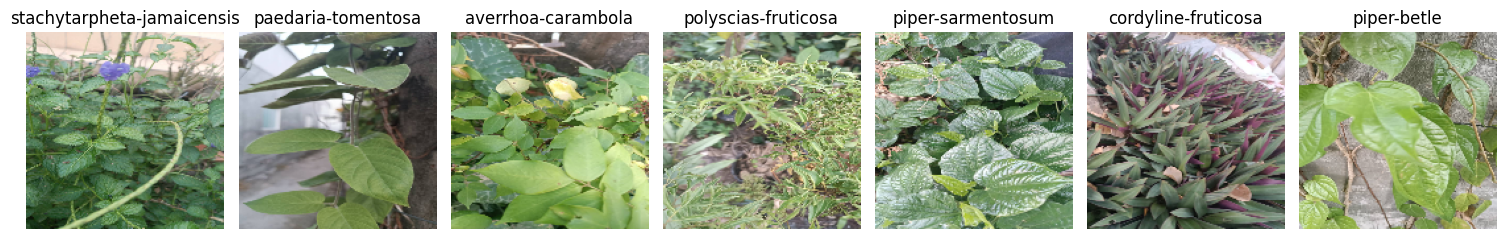

In [4]:
def plot_one_image_per_label(images, labels):
    unique_labels = list(set(labels)) 
    
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    
    for i, label in enumerate(unique_labels):
        idx = labels.index(label)
        axes[i].imshow(cv.cvtColor(images[idx], cv.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_one_image_per_label(data_resized, labels)

### Tahap 4: Konversi ke Grayscale

Kode di bawah berfungsi untuk mengubah gambar-gambar dalam daftar menjadi gambar skala abu-abu dan kemudian menampilkan satu gambar skala abu-abu untuk setiap label unik. Pertama, fungsi "convert_to_grayscale" akan mengubah setiap gambar dalam daftar menjadi skala abu-abu menggunakan OpenCV dan mengembalikan daftar gambar-gambar yang telah diubah. Setelah itu, gambar-gambar skala abu-abu ini ditampilkan menggunakan fungsi "plot_one_image_per_label", yang menampilkan satu gambar per label unik dalam dataset. Hasil akhirnya adalah daftar gambar yang sudah diubah menjadi skala abu-abu dan visualisasi yang menampilkan satu gambar skala abu-abu per label unik.

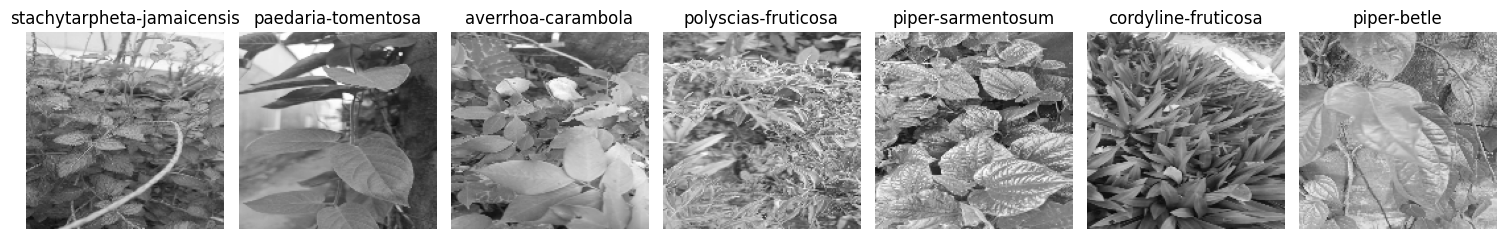

In [5]:
def convert_to_grayscale(images):
    grayscale_images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]
    return grayscale_images

data_grayscale = convert_to_grayscale(data_resized)
plot_one_image_per_label(data_grayscale, labels)


### Tahap 5: Thresholding

Kode di bawah ini berfungsi untuk mengaplikasikan metode thresholding pada gambar-gambar skala abu-abu dan kemudian menampilkan satu gambar hasil thresholding untuk setiap label unik. Pertama, fungsi "apply_threshold" mengaplikasikan thresholding Otsu pada setiap gambar dalam daftar, yang mengubah gambar menjadi biner (hitam-putih) dan menambahkan hasilnya ke daftar baru. Setelah itu, gambar-gambar hasil thresholding ini ditampilkan menggunakan fungsi "plot_one_image_per_label", yang menampilkan satu gambar per label unik dalam dataset. Hasil akhirnya adalah daftar gambar yang sudah di-threshold menjadi gambar biner dan visualisasi yang menampilkan satu gambar biner per label unik.

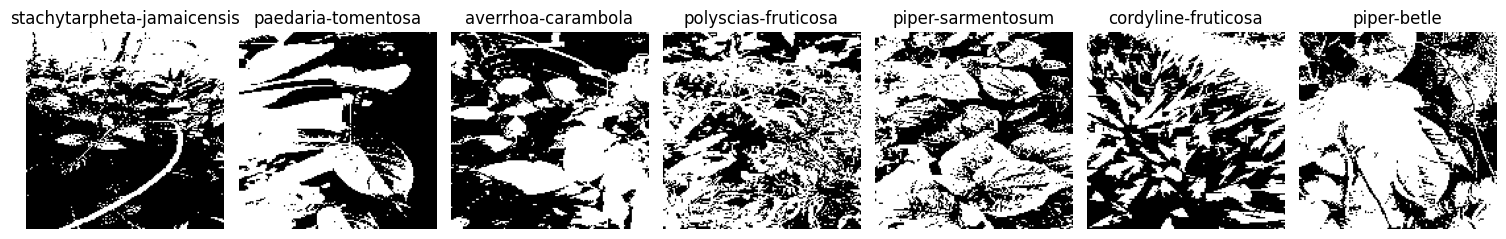

In [6]:
def apply_threshold(images):
    thresholded_images = []
    for img in images:
        ret, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        thresholded_images.append(thresh)
    return thresholded_images

data_thresholded = apply_threshold(data_grayscale)
plot_one_image_per_label(data_thresholded, labels)

### Tahap 6: Deteksi Tepi

Kode di atas berfungsi untuk mendeteksi tepi pada gambar-gambar biner dan kemudian menampilkan satu gambar hasil deteksi tepi untuk setiap label unik. Pertama, fungsi "detect_edges" menggunakan algoritma Canny untuk mendeteksi tepi pada setiap gambar dalam daftar, dengan nilai ambang bawah 50 dan nilai ambang atas 150, dan mengembalikan daftar gambar yang telah dideteksi tepinya. Setelah itu, gambar-gambar hasil deteksi tepi ini ditampilkan menggunakan fungsi "plot_one_image_per_label", yang menampilkan satu gambar hasil deteksi tepi per label unik dalam dataset. Hasil akhirnya adalah daftar gambar yang sudah dideteksi tepianya dan visualisasi yang menampilkan satu gambar dengan tepi terdeteksi per label unik.

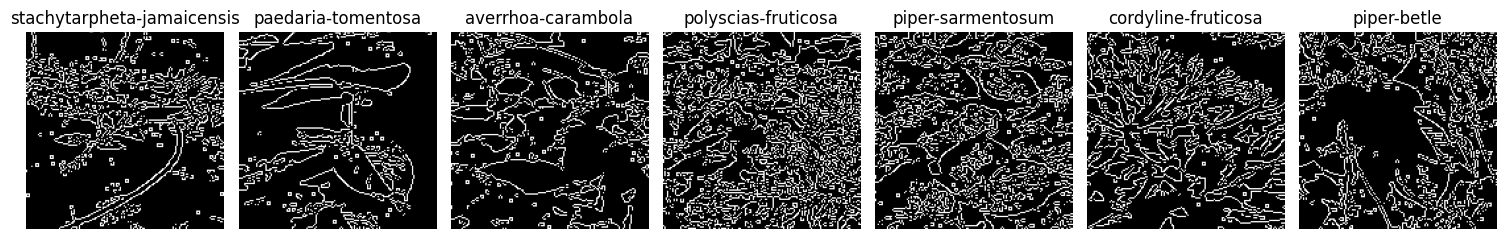

In [7]:
def detect_edges(images):
    edged_images = [cv.Canny(img, 50, 150) for img in images]
    return edged_images

data_edged = detect_edges(data_thresholded)
plot_one_image_per_label(data_edged, labels)

### Tahap 7: Normalisasi

In [8]:
data_normalized = np.array(data_edged).reshape(-1, 150, 150, 1) / 255.0
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded, num_classes=len(set(labels)))


Kode di atas berfungsi untuk menormalkan gambar hasil deteksi tepi dan mengubah labelnya menjadi format yang sesuai untuk model pembelajaran mesin.

Pertama, gambar-gambar biner hasil deteksi tepi diubah menjadi array numpy dan dinormalisasi. Array gambar ini diubah bentuknya menjadi dimensi yang sesuai (150x150 piksel dengan satu channel grayscale) dan dinormalisasi dengan membagi nilai pikselnya dengan 255 sehingga berada dalam rentang 0-1.

Hasil akhirnya adalah dua array, yaitu data_normalized, yaitu Array yang berisi gambar-gambar yang sudah dinormalisasi dengan dimensi yang sesuai untuk digunakan dalam model pembelajaran mesin dan labels_onehot, yaitu Array yang berisi label-label yang sudah diubah menjadi one-hot encoding, siap untuk digunakan dalam pelatihan model pembelajaran mesin.

### Tahap 8: Split Data

In [9]:
xTrain, xTest, yTrain, yTest = train_test_split(data_normalized, labels_onehot, test_size=0.2, random_state=42)

Kode di atas digunakan untuk membagi data menjadi empat bagian untuk proses training. Pertama xTrain, data gambar untuk pelatihan (80% dari data, sebagai input). Kedua xTest, data gambar untuk pengujian (20% dari data, sebagai input). Ketiga yTrain, Label one-hot encoding untuk pelatihan (80% dari data, sebagai output yang diharapkan).
Keempat Test, Label one-hot encoding untuk pengujian (20% dari data, sebagai output yang diharapkan). Kelima test_size=0.2, menentukan bahwa 20% dari data akan digunakan untuk pengujian, sementara 80%nya digunakan untuk pelatihan. Terakhir random_state=42 yang digunakan untuk menghasilkan pembagian yang sama setiap kali kode dijalankan, sehingga hasilnya dapat direproduksi.

### Tahap 9: Bangun Model CNN

Kode di bawah ini merupakan pendefinisian model CNN. Model CNN menggunakan Sequential() untuk menambahkan layer secara berurutan. Pertama, ada tiga layer konvolusi dengan jumlah filter berturut-turut 32, 64, dan 128, masing-masing dengan aktivasi ReLU, diikuti oleh layer MaxPooling2D untuk mengurangi dimensi gambar.

Hasilnya kemudian diubah menjadi vektor satu dimensi dengan Flatten() dan dimasukkan ke dalam layer fully connected (Dense) dengan 128 neuron. Untuk mengurangi overfitting, digunakan Dropout dengan dropout rate 0.5 sebelum layer fully connected terakhir. Output akhir menggunakan fungsi aktivasi softmax untuk klasifikasi multi-kelas, dengan jumlah neuron sesuai dengan jumlah kelas unik dari dataset.

Model dikompilasi dengan optimizer 'adam', loss function 'categorical_crossentropy' untuk klasifikasi multi-kelas, dan metrik 'accuracy' untuk evaluasi kinerja selama pelatihan. Selama proses pelatihan dengan model.fit(), model dipelajari dengan data latih selama 20 epochs, dengan evaluasi menggunakan data uji untuk memantau kinerja generalisasi model dari data latih ke data uji.

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(set(labels)), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(xTrain, yTrain, epochs=20, validation_data=(xTest, yTest))


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.1332 - loss: 2.2506 - val_accuracy: 0.1690 - val_loss: 1.9312
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.2226 - loss: 1.9003 - val_accuracy: 0.4648 - val_loss: 1.7141
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.4276 - loss: 1.6111 - val_accuracy: 0.5141 - val_loss: 1.2949
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.6463 - loss: 1.0745 - val_accuracy: 0.6338 - val_loss: 1.0715
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.7918 - loss: 0.6521 - val_accuracy: 0.5986 - val_loss: 1.0510
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.8723 - loss: 0.3786 - val_accuracy: 0.5915 - val_loss: 1.1401
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9368 - loss: 0.2080 - val_accuracy: 0.6197 - val_loss: 1.2495
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9070 - loss: 0.2439 - val_accuracy: 0.

### Tahap 10: Evaluasi Model dan Visualisasi

Kode di bawah ini melakukan evaluasi terhadap model CNN yang telah dilatih menggunakan data uji. Pertama, model melakukan prediksi terhadap data uji (xTest) dan hasilnya diubah menjadi kelas prediksi menggunakan np.argmax. Selanjutnya, classification_report dari sklearn.metrics digunakan untuk mencetak laporan evaluasi model, termasuk precision, recall, dan F1-score untuk setiap kelas. Hal ini memberikan pemahaman yang mendalam tentang kemampuan model dalam mengklasifikasikan gambar-gambar yang belum pernah dilihat sebelumnya, yang penting untuk mengevaluasi performa model secara keseluruhan dan identifikasi area untuk perbaikan lebih lanjut.

In [11]:
yPred = model.predict(xTest)
yPred_classes = np.argmax(yPred, axis=1)
yTrue = np.argmax(yTest, axis=1)

print("Evaluasi Model CNN:")
print(classification_report(yTrue, yPred_classes, target_names=label_encoder.classes_, zero_division=0))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Evaluasi Model CNN:
                            precision    recall  f1-score   support

        averrhoa-carambola       0.73      0.59      0.65        27
       cordyline-fruticosa       0.83      0.68      0.75        28
        paedaria-tomentosa       0.50      0.60      0.55        20
               piper-betle       0.50      0.50      0.50        22
         piper-sarmentosum       0.44      0.44      0.44         9
       polyscias-fruticosa       0.77      0.89      0.83        19
stachytarpheta-jamaicensis       0.50      0.59      0.54        17

                  accuracy                           0.63       142
                 macro avg       0.61      0.61      0.61       142
              weighted avg       0.64      0.63      0.63       142



Kode tersebut digunakan untuk membuat dan menampilkan confusion matrix, yang merupakan alat visualisasi yang penting untuk mengevaluasi performa model CNN terhadap data uji. Confusion matrix menampilkan jumlah prediksi yang benar dan salah untuk setiap kelas, dengan diagonal utama mewakili prediksi yang tepat dan sel di luar diagonal menunjukkan kesalahan prediksi antar kelas. Heatmap yang dihasilkan menggunakan seaborn ("sns.heatmap") memberikan representasi visual yang jelas dengan intensitas warna biru yang menggambarkan seberapa sering setiap pasangan kelas tertentu salah diprediksi. Evaluasi ini membantu dalam memahami di mana model cenderung salah atau benar dalam prediksi, serta untuk mengidentifikasi kelas-kelas yang memerlukan perhatian lebih lanjut dalam pengembangan model.

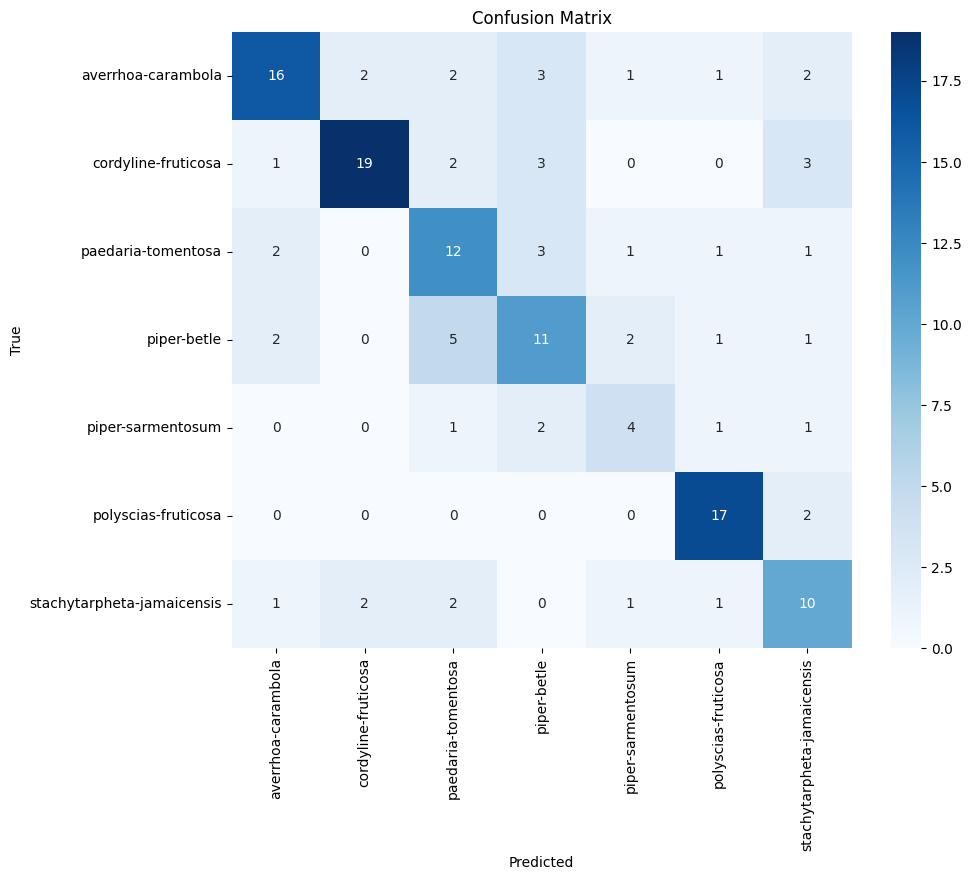

In [12]:
cm = confusion_matrix(yTrue, yPred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

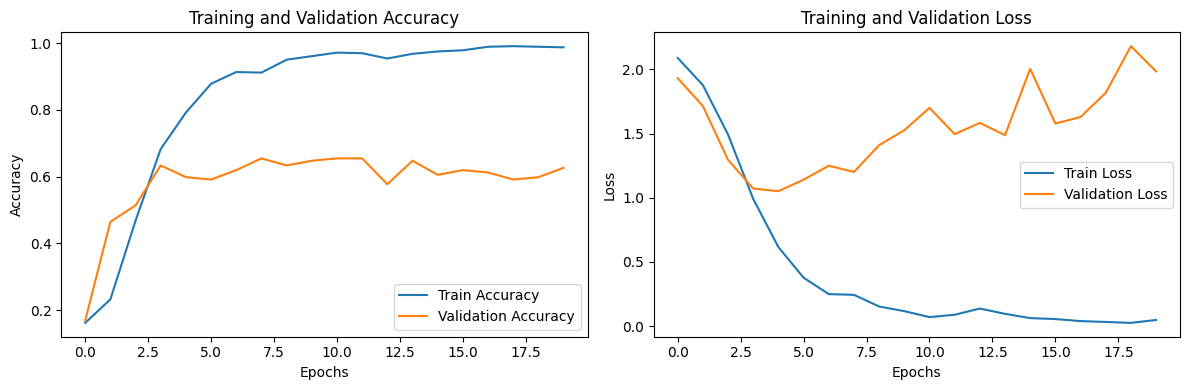

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### Tahap 11: Implementasi SVM, KKN, Random Forest

In [14]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings


# Ekstraksi Fitur
xTrain_flat = xTrain.reshape(xTrain.shape[0], -1)
xTest_flat = xTest.reshape(xTest.shape[0], -1)


Kode di atas digunakan untuk membuat visualisasi dari metrik pelatihan dan validasi (training and validation) dari model CNN selama proses pelatihan. Pada subplot pertama (1, 2, 1), grafik menampilkan nilai akurasi dari data latih dan data validasi terhadap jumlah epoch. Ini membantu memantau bagaimana performa model meningkat atau stagnan seiring berjalannya waktu. Pada subplot kedua (1, 2, 2), grafik menunjukkan nilai loss dari data latih dan data validasi terhadap jumlah epoch. Tujuan dari grafik ini adalah untuk melihat bagaimana loss model berubah selama pelatihan, di mana penurunan loss menunjukkan model semakin baik dalam mempelajari pola dari data. Penggunaan `plt.tight_layout()` memastikan tata letak plot yang rapi, dan `plt.show()` menampilkan plot secara keseluruhan untuk evaluasi visual yang lebih baik terhadap performa model CNN.

### Implementasi SVM

Kode di atas mengimplementasikan pendekatan SVM (Support Vector Machine) untuk klasifikasi gambar yang sudah diubah menjadi bentuk vektor satu dimensi. SVM menggunakan kernel linear untuk memisahkan kelas-kelas dalam ruang fitur yang diberikan. Setelah dilatih dengan data latih, model SVM melakukan prediksi terhadap data uji untuk menghasilkan "svm_pred". Evaluasi model dilakukan dengan mencetak laporan klasifikasi menggunakan "classification_report" dari "sklearn.metrics", yang mencakup metrik seperti precision, recall, dan F1-score untuk setiap kelas. Hal ini memberikan gambaran tentang performa SVM dalam mengklasifikasikan gambar-gambar dari kelas-kelas yang berbeda, dengan tujuan untuk memahami kekuatan dan kelemahan model serta identifikasi area untuk perbaikan lebih lanjut.

In [15]:

svm = SVC(kernel='linear')
svm.fit(xTrain_flat, yTrain.argmax(axis=1))
svm_pred = svm.predict(xTest_flat)
print("Evaluasi SVM:")
print(classification_report(yTrue, svm_pred, target_names=label_encoder.classes_, zero_division=0))


Evaluasi SVM:
                            precision    recall  f1-score   support

        averrhoa-carambola       0.82      0.67      0.73        27
       cordyline-fruticosa       0.47      0.57      0.52        28
        paedaria-tomentosa       0.40      0.50      0.44        20
               piper-betle       0.50      0.45      0.48        22
         piper-sarmentosum       0.00      0.00      0.00         9
       polyscias-fruticosa       0.73      1.00      0.84        19
stachytarpheta-jamaicensis       0.60      0.53      0.56        17

                  accuracy                           0.58       142
                 macro avg       0.50      0.53      0.51       142
              weighted avg       0.55      0.58      0.56       142



### Visualisasi Hasil Evaluasi SVM

Kode di bawah ini digunakan untuk membuat dan menampilkan confusion matrix dari hasil evaluasi SVM terhadap data uji. Confusion matrix adalah alat visual yang memperlihatkan jumlah prediksi yang benar dan salah untuk setiap kelas. Dalam heatmap yang dihasilkan menggunakan seaborn, warna biru menunjukkan intensitas yang menggambarkan seberapa sering setiap pasangan kelas tertentu salah diprediksi oleh model SVM. Label sumbu x dan y menggunakan "xticklabels" dan "yticklabels" dari "label_encoder.classes_", yang menampilkan nama kelas yang sesuai dengan prediksi dan nilai sebenarnya. Evaluasi ini membantu untuk memahami di mana SVM cenderung salah atau benar dalam prediksi kelas, memberikan gambaran yang jelas tentang performa model dalam mengklasifikasikan data uji dari kelas-kelas yang berbeda.

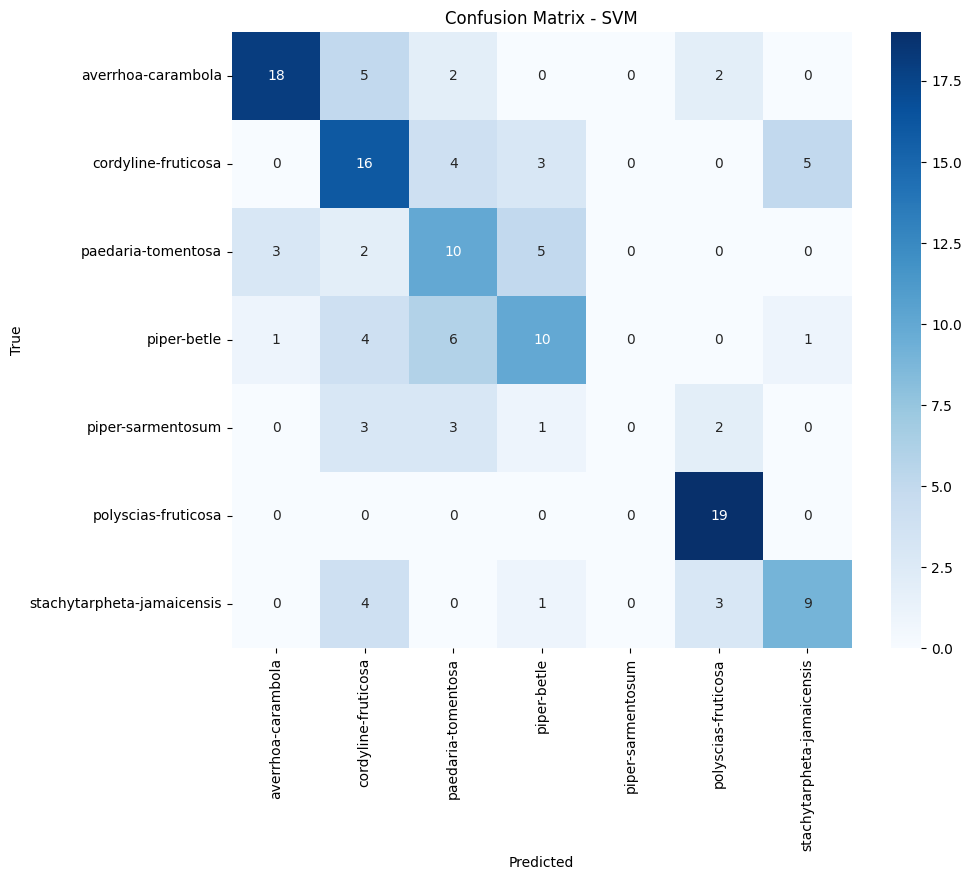

In [16]:
plt.figure(figsize=(10, 8))
svm_cm = confusion_matrix(yTrue, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

### Implementasi Model KNN

Kode di bawah ini mengimplementasikan pendekatan KNN (K-Nearest Neighbors) untuk klasifikasi gambar yang sudah diubah menjadi bentuk vektor satu dimensi. Dalam konfigurasi ini, KNN menggunakan parameter "n_neighbors=3", yang berarti untuk setiap sampel yang akan diprediksi, model akan mempertimbangkan 3 tetangga terdekat dari data latih untuk menentukan kelas prediksi. Setelah dilatih dengan data latih, model KNN melakukan prediksi terhadap data uji untuk menghasilkan "knn_pred". Evaluasi model dilakukan dengan mencetak laporan klasifikasi menggunakan "classification_report" dari "sklearn.metrics", yang mencakup metrik seperti precision, recall, dan F1-score untuk setiap kelas. Tujuan dari evaluasi ini adalah untuk memahami seberapa baik KNN dapat mengklasifikasikan gambar-gambar dari kelas-kelas yang berbeda, serta untuk mengidentifikasi kekuatan dan kelemahan model dalam pengelompokan berdasarkan tetangga terdekat.

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xTrain_flat, yTrain.argmax(axis=1))
knn_pred = knn.predict(xTest_flat)
print("Evaluasi KNN:")
print(classification_report(yTrue, knn_pred, target_names=label_encoder.classes_, zero_division=0))


Evaluasi KNN:
                            precision    recall  f1-score   support

        averrhoa-carambola       0.50      0.04      0.07        27
       cordyline-fruticosa       0.50      0.04      0.07        28
        paedaria-tomentosa       0.14      1.00      0.25        20
               piper-betle       0.00      0.00      0.00        22
         piper-sarmentosum       0.00      0.00      0.00         9
       polyscias-fruticosa       0.00      0.00      0.00        19
stachytarpheta-jamaicensis       0.00      0.00      0.00        17

                  accuracy                           0.15       142
                 macro avg       0.16      0.15      0.06       142
              weighted avg       0.21      0.15      0.06       142



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


### Visualisasi Confussion Matrix untuk KNN

Kode di bawah ini akan membuat confusion matrix untuk evaluasi model KNN terhadap data uji, dimana matriks ini adalah alat visual yang berguna untuk memahami seberapa baik model KNN dapat memprediksi kelas-kelas dari data uji. Dalam heatmap yang dihasilkan, warna biru menunjukkan intensitas yang menggambarkan seberapa sering setiap pasangan kelas tertentu salah diprediksi oleh model KNN. Label pada sumbu x dan y menggunakan "xticklabels" dan "yticklabels" dari "label_encoder.classes_", yang menampilkan nama kelas yang sesuai dengan prediksi dan nilai sebenarnya. Evaluasi ini membantu untuk mengevaluasi performa model dalam mengklasifikasikan data uji berdasarkan metrik seperti presisi, recall, dan F1-score untuk setiap kelas, yang memberikan wawasan yang jelas tentang kekuatan dan potensi kelemahan KNN dalam konteks klasifikasi gambar.

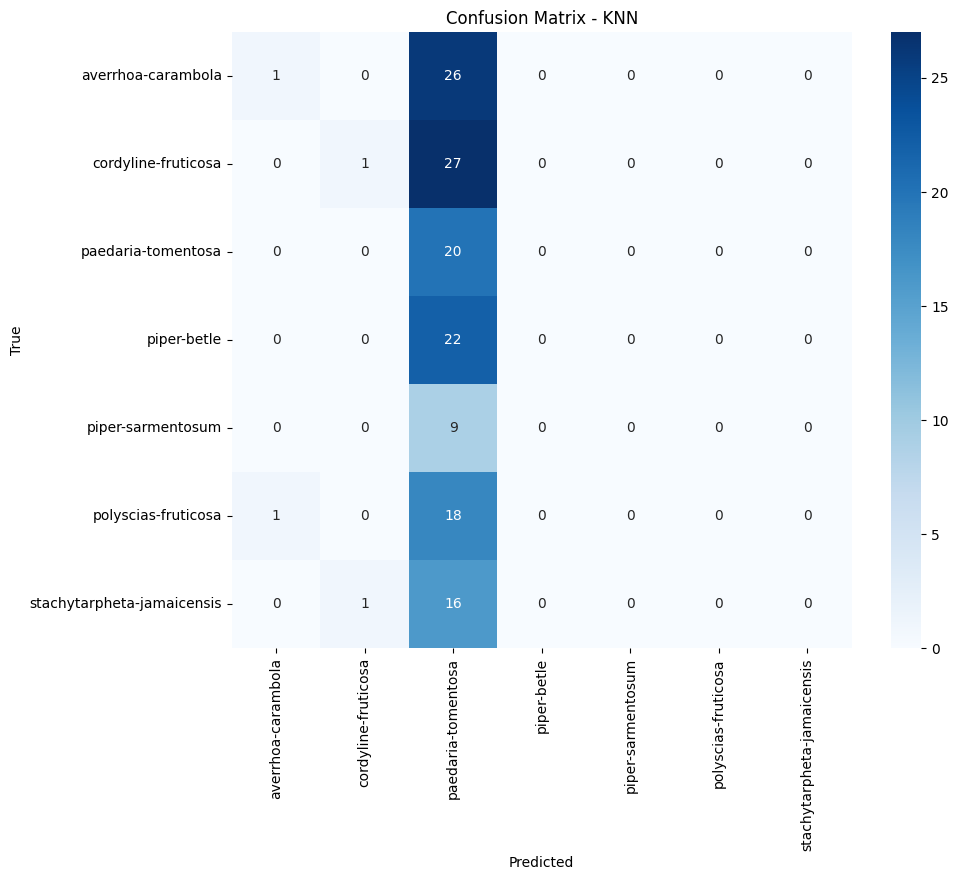

In [18]:
plt.figure(figsize=(10, 8))
knn_cm = confusion_matrix(yTrue, knn_pred)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()

### Implementasi Model Random Forest

Kode di atas menggunakan pendekatan Random Forest untuk mengklasifikasikan gambar yang telah diubah menjadi vektor satu dimensi. Random Forest mengoperasikan 100 pohon keputusan, di mana setiap pohon memberikan prediksi berdasarkan fitur-fitur dari data latih. Setelah dilatih dengan data latih, model Random Forest melakukan prediksi terhadap data uji untuk menghasilkan "rf_pred". Evaluasi model dilakukan dengan mencetak laporan klasifikasi menggunakan "classification_report" dari "sklearn.metrics", yang mencakup metrik seperti presisi, recall, dan F1-score untuk setiap kelas. Hasil evaluasi ini memberikan gambaran yang jelas tentang kemampuan Random Forest dalam mengklasifikasikan gambar-gambar dari kelas-kelas yang berbeda, dengan tujuan untuk memahami kekuatan serta potensi kelemahan model dalam konteks klasifikasi gambar.

In [19]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(xTrain_flat, yTrain.argmax(axis=1))
rf_pred = rf.predict(xTest_flat)
print("Evaluasi Random Forest:")
print(classification_report(yTrue, rf_pred, target_names=label_encoder.classes_, zero_division=0))


Evaluasi Random Forest:
                            precision    recall  f1-score   support

        averrhoa-carambola       0.50      0.52      0.51        27
       cordyline-fruticosa       0.14      0.21      0.17        28
        paedaria-tomentosa       0.19      0.25      0.22        20
               piper-betle       0.25      0.14      0.18        22
         piper-sarmentosum       0.00      0.00      0.00         9
       polyscias-fruticosa       0.53      0.53      0.53        19
stachytarpheta-jamaicensis       0.27      0.24      0.25        17

                  accuracy                           0.30       142
                 macro avg       0.27      0.27      0.26       142
              weighted avg       0.29      0.30      0.29       142



# Visualisasi Confussion Matrix untuk Random Forest

Potongan Code di bawah ini digunakan untuk visualisasi hasil modeling random forest. Grafik yang ditampilkan adalah confusion matrix yang dibuat untuk mengevaluasi model Random Forest terhadap data uji. Confusion matrix adalah alat visual yang membantu untuk memahami seberapa baik model dapat memprediksi kelas-kelas dari data yang diberikan. Dalam heatmap yang dihasilkan, intensitas warna biru menggambarkan seberapa sering setiap pasangan kelas tertentu salah diprediksi oleh model Random Forest. Label pada sumbu x dan y menggunakan "xticklabels" dan "yticklabels" dari "label_encoder.classes_", yang menampilkan nama kelas yang sesuai dengan prediksi dan nilai sebenarnya. Evaluasi ini memberikan informasi yang penting tentang kinerja model dalam mengklasifikasikan gambar-gambar ke dalam kelas-kelas yang berbeda, sehingga membantu untuk mengevaluasi keandalan dan efektivitas model dalam tugas klasifikasi gambar.

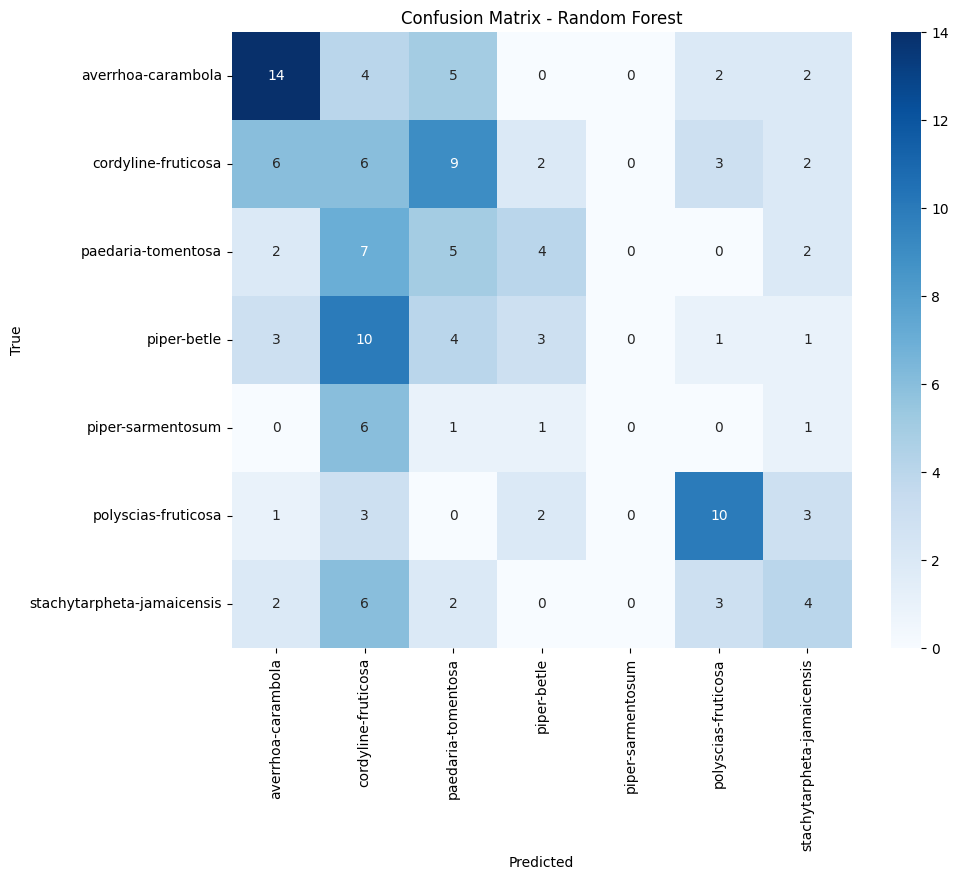

In [20]:
plt.figure(figsize=(10, 8))
rf_cm = confusion_matrix(yTrue, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()